# Working example with hierarchical sampling

Follow the example of [Comparing Different Query Strategies](https://libact.readthedocs.io/en/latest/examples/plot.html)

The `qs3` is example of Hierarchical Sampling.

In [1]:
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import *
from libact.query_strategies import *
from libact.query_strategies.multiclass import HierarchicalSampling
from libact.labelers import IdealLabeler

In [2]:
def run(trn_ds, tst_ds, lbr, model, qs, quota):
    E_in, E_out = [], []

    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        E_in = np.append(E_in, 1 - model.score(trn_ds))
        E_out = np.append(E_out, 1 - model.score(tst_ds))

    return E_in, E_out

In [3]:
def split_train_test(dataset_filepath, test_size, n_labeled):
    X, y = import_libsvm_sparse(dataset_filepath).format_sklearn()

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds

In [4]:
%matplotlib inline

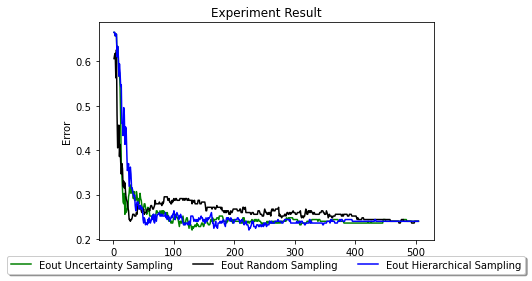

In [5]:
# Specifiy the parameters here:
# path to your binary classification dataset
dataset_filepath = os.path.join(
    os.path.dirname(os.path.realpath("./examples")), 'diabetes.txt')
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 10      # number of samples that are initially labeled

# Load dataset
trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
    split_train_test(dataset_filepath, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query

# Comparing UncertaintySampling strategy with RandomSampling.
# model is the base learner, e.g. LogisticRegression, SVM ... etc.
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

qs2 = RandomSampling(trn_ds2)
model = LogisticRegression()
E_in_2, E_out_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota)

sub_qs = UncertaintySampling(trn_ds3, method='sm', model=LogisticRegression())
qs3 = HierarchicalSampling(trn_ds3, np.unique(y_train), active_selecting=True, subsample_qs=sub_qs)
E_in_3, E_out_3 = run(trn_ds3, tst_ds, lbr, model, qs3, quota)

# Plot the learning curve of UncertaintySampling to RandomSampling
# The x-axis is the number of queries, and the y-axis is the corresponding
# error rate.
query_num = np.arange(1, quota + 1)
# plt.plot(query_num, E_in_1, 'b', label='qs Ein')
# plt.plot(query_num, E_in_2, 'r', label='random Ein')
plt.plot(query_num, E_out_1, 'g', label='Eout Uncertainty Sampling')
plt.plot(query_num, E_out_2, 'k', label='Eout Random Sampling')
plt.plot(query_num, E_out_3, 'b', label="Eout Hierarchical Sampling")
plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Experiment Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.show()

# Hierarchical clustering \#185

First I reproduce the issue 185 first.

In [6]:
X_pool, y_pool = import_libsvm_sparse(dataset_filepath).format_sklearn()

n_labeled = 10
seed_set = range(n_labeled)
y = []
for idx in range(len(y_pool)):
    if idx in seed_set:
        y += [y_pool[idx]]
    else:
        y += [None]
dataset = Dataset(X_pool, y)
print(dataset.len_labeled())
sub_qs = UncertaintySampling(
    dataset, method='sm', model=LogisticRegression(max_iter=1000)
)
qs = HierarchicalSampling(
    dataset, # Dataset object
    np.unique(y_pool),
    active_selecting=True,
    subsample_qs=sub_qs
)

for idx in range(100):
    a = qs.make_query()
    qs.update(a, y_pool[a])
print(dataset.len_labeled())

10


AssertionError: 

I consider that the `AssertionError` occurs as we use only **query strategy update** here.
When next time `qs.make_query()`, the former corresponded labeled in `dataset` doesn't update.

In `libact`, we prefer use `dataset.update`
[detail of dataset.update](https://github.com/ntucllab/libact/blob/2432b512bca3bdf97df6d2d7c40c5ffba5b46094/libact/base/dataset.py#L133).
Or we could follow the steps of `dataset.update`.

In [7]:
X_pool, y_pool = import_libsvm_sparse(dataset_filepath).format_sklearn()

n_labeled = 10
seed_set = range(n_labeled)
y = []
for idx in range(len(y_pool)):
    if idx in seed_set:
        y += [y_pool[idx]]
    else:
        y += [None]
dataset = Dataset(X_pool, y)
print(dataset.len_labeled())
sub_qs = UncertaintySampling(
    dataset, method='sm', model=LogisticRegression(max_iter=1000)
)
qs = HierarchicalSampling(
    dataset, # Dataset object
    np.unique(y_pool),
    active_selecting=True,
    subsample_qs=sub_qs
)

for idx in range(100):
    a = qs.make_query()
    # dataset.update(a, y_pool[a]) # ok!
    dataset._y[a] = y_pool[a]
    dataset.modified = True
    qs.update(a, y_pool[a])
print(dataset.len_labeled())

10
110
